In [1]:

import numpy as np, pandas as pd
import matplotlib.pyplot as plt, seaborn as sns

#Example5.01: Prediciting sales from advertisments spend using linear regression

advertising = pd.read_csv('Datasets/advertising.csv')
advertising.head()


,TV,Radio,Newspaper,Sales
0,230.1,37.8,69.2,22.1
1,44.5,39.3,45.1,10.4
2,17.2,45.9,69.3,12.0
3,151.5,41.3,58.5,16.5
4,180.8,10.8,58.4,17.9


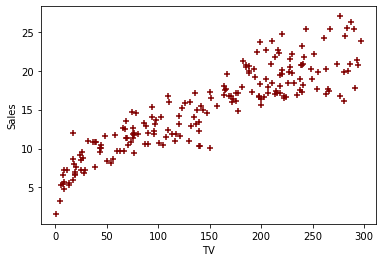

In [2]:
#visualize the association between TV and Sales
plt.scatter(advertising.TV, advertising.Sales, marker='+', color='Maroon')

plt.xlabel('TV')
plt.ylabel('Sales')
plt.show()

In [3]:
#importing Linear Regression

from sklearn.linear_model import LinearRegression

lr = LinearRegression()

In [4]:
#fit the model

lr.fit(advertising[['TV']],advertising[['Sales']])

LinearRegression()

In [5]:
#predict the model

sales_pred = lr.predict(advertising[['TV']])

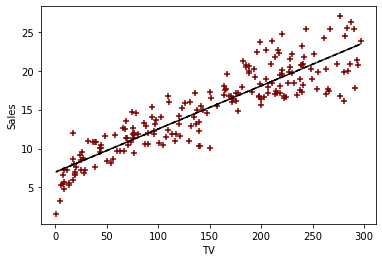

In [6]:
#plot the results

plt.plot(advertising.TV, sales_pred,'k--')
plt.scatter(advertising.TV, advertising.Sales,
           marker='+', color='Maroon')
plt.xlabel('TV')
plt.ylabel('Sales')
plt.show()

In [1]:
#End 5.01


In [7]:
#5.02: Creating Features for Customer Revenue Prediciton 

#seeking to identify high value customers, and create a different marketing plan for them. 
#create a predicitive model employed to predict next years revenue of the customer based on the previous years purchase
#A customer with a higher predicted revenue value is naturally a higher value customer. 

#manipulate data to create variables that will allow you to model customer spend.

#Create the following Variables: 
#Revenue_2019(Total revenue for the year 2019)
#days_since_first_purchase
#days_since_lase_purchase
#number_of_purchases
#avg_order_cost
#revenue_2020

import datetime as dt

df = pd.read_csv('Datasets/azra_retail_transactions.csv')
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,546729,22775,PURPLE DRAWERKNOB ACRYLIC EDWARDIAN,12,2020-03-16 11:36:00,1.25,18231.0,United Kingdom
1,559898,21868,POTTING SHED TEA MUG,6,2020-07-13 12:18:00,1.25,16225.0,United Kingdom
2,548648,71459,HANGING JAM JAR T-LIGHT HOLDER,24,2020-04-01 13:20:00,0.85,12949.0,United Kingdom
3,540543,22173,METAL 4 HOOK HANGER FRENCH CHATEAU,4,2020-01-09 15:23:00,2.95,14395.0,United Kingdom
4,561390,20726,LUNCH BAG WOODLAND,10,2020-07-27 09:52:00,1.65,17068.0,United Kingdom


In [8]:
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

In [9]:
df['revenue'] = df['Quantity']*df['UnitPrice']

In [10]:
operations = {'revenue':'sum',
             'InvoiceDate':'first',
             'CustomerID':'first',}
df= df.groupby('InvoiceNo').agg(operations)

In [11]:
df.head()

,revenue,InvoiceDate,CustomerID
InvoiceNo,,,
536365,139.12,2019-12-01 08:26:00,17850.0
536366,22.20,2019-12-01 08:28:00,17850.0
536367,278.73,2019-12-01 08:34:00,13047.0
536368,70.05,2019-12-01 08:34:00,13047.0
536369,17.85,2019-12-01 08:35:00,13047.0


In [12]:
df['year'] = df['InvoiceDate'].dt.year #creating a separate column for year 2019

In [13]:
#calculate how many days difference there is between the last day of 2019 and the invoice date 

df['days_since'] = (dt.datetime(year=2019, month=12, day=31)
                   - df['InvoiceDate']).apply(lambda x: x.days)

In [14]:
#creating feature for Days Since

operations = {'revenue':'sum',
             'days_since':['max','min','nunique']}

X= df[df['year'] ==2019].groupby('CustomerID').agg(operations)

In [15]:
X.head()

revenue days_since            
                sum        max min nunique
CustomerID                                
12347.0      711.79         23  23       1
12348.0      892.80         14  14       1
12370.0     1868.02         16  13       2
12377.0     1001.52         10  10       1
12383.0      600.72          8   8       1

In [16]:
#reset the names of the columns to make them easier to refer to later

X.columns = [' '.join(col).strip() for col in X.columns.values]

X.head()

,revenue sum,days_since max,days_since min,days_since nunique
CustomerID,,,,
12347.0,711.79,23,23,1
12348.0,892.80,14,14,1
12370.0,1868.02,16,13,2
12377.0,1001.52,10,10,1
12383.0,600.72,8,8,1


In [17]:
#average spend per oder

X['avg_order_cost'] = X['revenue sum']/X['days_since nunique']

In [18]:
#create a y vairiable for the prediction

y = df[df['year'] == 2020].groupby('CustomerID')['revenue'].sum()

In [19]:
#put predictors and outcomes in a single dataframe

wrangled_df = pd.concat([X,y],axis=1)

wrangled_df.columns = ['revenue_2019',
                      'days_since_first_purchase',
                      'days_since_last_purchase',
                      'number_of_purchases',
                      'avg_order_cost',
                      'revenue_2020']

wrangled_df.head()

,revenue_2019,days_since_first_purchase,days_since_last_purchase,number_of_purchases,avg_order_cost,revenue_2020
CustomerID,,,,,,
12346.0,NaN,NaN,NaN,NaN,NaN,77183.60
12347.0,711.79,23.0,23.0,1.0,711.79,3598.21
12348.0,892.80,14.0,14.0,1.0,892.80,904.44
12349.0,NaN,NaN,NaN,NaN,NaN,1757.55
12350.0,NaN,NaN,NaN,NaN,NaN,334.40


In [20]:
#NaN are customers who were active wither only in 2019 or 2020. Will learn later how to predict churn. for now drop NaN
#This will make the model predict the spending of those if they remain active

wrangled_df = wrangled_df[~wrangled_df.revenue_2019.isnull()]

wrangled_df = wrangled_df[~wrangled_df.revenue_2020.isnull()]

In [21]:
#get rid of ooutliers


wrangled_df = wrangled_df[wrangled_df.revenue_2020
                         < ((wrangled_df.revenue_2020.median())
                           + wrangled_df.revenue_2020.std()*3)]

wrangled_df = wrangled_df[wrangled_df.revenue_2019
                         < ((wrangled_df.revenue_2019.median())
                           + wrangled_df.revenue_2019.std()*3)]


In [22]:
#covert to dataframe to csv Final Clean DataSet


wrangled_df.to_csv('wrangled_transactions.csv')
wrangled_df.head()

,revenue_2019,days_since_first_purchase,days_since_last_purchase,number_of_purchases,avg_order_cost,revenue_2020
CustomerID,,,,,,
12347.0,711.79,23.0,23.0,1.0,711.79,3598.21
12348.0,892.80,14.0,14.0,1.0,892.80,904.44
12370.0,1868.02,16.0,13.0,2.0,934.01,1677.67
12377.0,1001.52,10.0,10.0,1.0,1001.52,626.60
12383.0,600.72,8.0,8.0,1.0,600.72,1249.84


In [26]:
wrangled_df.corr() # correlation of a Dataframe (df) closer to 0 = no correlation, closer to 1 = strong association



,revenue_2019,days_since_first_purchase,days_since_last_purchase,number_of_purchases,avg_order_cost,revenue_2020
revenue_2019,1.000000,0.109692,-0.254964,0.504438,0.779401,0.548234
days_since_first_purchase,0.109692,1.000000,0.641574,0.327502,-0.074321,0.061743
days_since_last_purchase,-0.254964,0.641574,1.000000,-0.398268,-0.054051,-0.171294
number_of_purchases,0.504438,0.327502,-0.398268,1.000000,-0.012466,0.355751
avg_order_cost,0.779401,-0.074321,-0.054051,-0.012466,1.000000,0.357384
revenue_2020,0.548234,0.061743,-0.171294,0.355751,0.357384,1.000000


In [27]:
#correlation between two series / lists / arrays use:
#import numpy as np
#np/corrcoef(Var1, var2)

In [2]:
#End 5.02


In [30]:
#Example 5.03: Examining Relationships between Predictors and the outcome.



df = pd.read_csv('Wrangled_Transactions.csv', index_col = 'CustomerID')

<AxesSubplot:xlabel='days_since_first_purchase', ylabel='revenue_2020'>

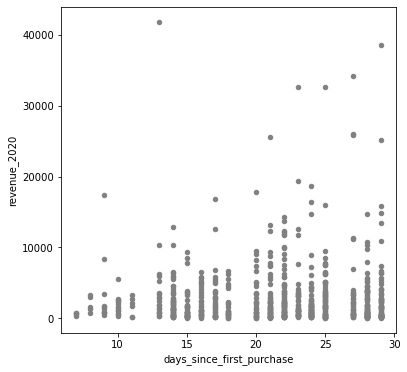

In [31]:
#Scatter Plot the dataframe w/ days_since_first_purchase as x-axis and revenue_2020 as y-axis
df.plot.scatter(x='days_since_first_purchase', y = 'revenue_2020',
               figsize=[6,6],color='gray')

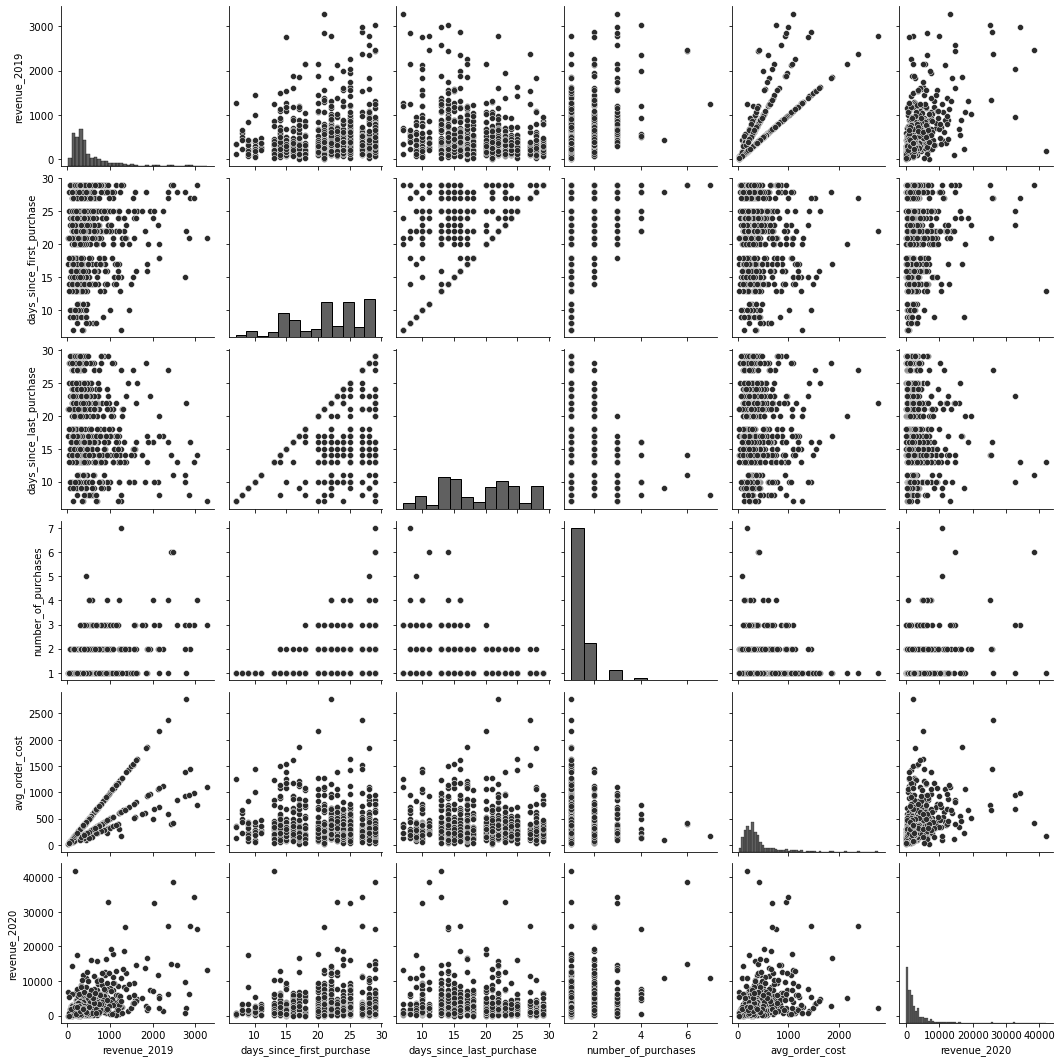

'Diagonal shows a histogram for each variable, \nwhereas each row shows the scatter plot between one variable and each other variable.\nThe bottom row shows the scatter plot of revene 2020 against other Variables.\n\nBecause the data points are overlapping and there is a fair amount of variance, the relationships do not look very clcear. \n\n\n'

In [33]:
import seaborn as sns

sns.set_palette('Greys_r')
sns.pairplot(df)
plt.show()

"""Diagonal shows a histogram for each variable, 
whereas each row shows the scatter plot between one variable and each other variable.
The bottom row shows the scatter plot of revene 2020 against other Variables.

Because the data points are overlapping and there is a fair amount of variance, the relationships do not look very clcear. 


"""

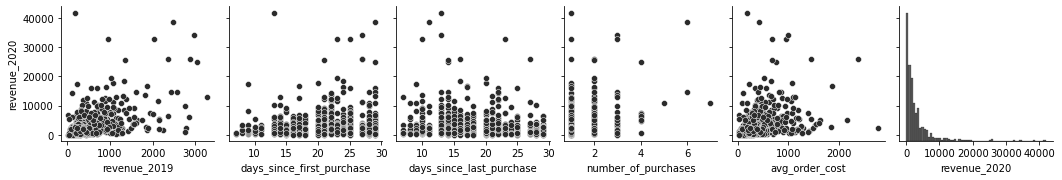

'Focused associations between revenue_2020 and independent variables. None of the predictors have a strong relationship with revenue_2020. The strongest relationship is revenue_2019'

In [35]:
sns.pairplot(df,x_vars=df.columns, y_vars='revenue_2020')
plt.show()

"""Focused associations between revenue_2020 and independent variables. None of the predictors have a strong relationship with revenue_2020. The strongest relationship is revenue_2019"""

In [41]:
#Use correlations to quantnify the associations between variables

df.corr()

,revenue_2019,days_since_first_purchase,days_since_last_purchase,number_of_purchases,avg_order_cost,revenue_2020
revenue_2019,1.000000,0.109692,-0.254964,0.504438,0.779401,0.548234
days_since_first_purchase,0.109692,1.000000,0.641574,0.327502,-0.074321,0.061743
days_since_last_purchase,-0.254964,0.641574,1.000000,-0.398268,-0.054051,-0.171294
number_of_purchases,0.504438,0.327502,-0.398268,1.000000,-0.012466,0.355751
avg_order_cost,0.779401,-0.074321,-0.054051,-0.012466,1.000000,0.357384
revenue_2020,0.548234,0.061743,-0.171294,0.355751,0.357384,1.000000


In [42]:
"""Positive numbers - greater the expected revenue from them in 2020
Negative number - Opposite, lower revenues expected"""

'Positive numbers - greater the expected revenue from them in 2020\nNegative number - Opposite, lower revenues expected'

In [47]:
#LinearRegression
"""
from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(X_train, y_train)

X_train = independent variables
y_train = dempendent variables

predictions = model.predict(new_data)

model.coef_  = displaying the models coefficients once trained

model.intercept_

"""

'\nfrom sklearn.linear_model import LinearRegression\nmodel = LinearRegression()\nmodel.fit(X_train, y_train)\n\nX_train = independent variables\ny_train = dempendent variables\n\npredictions = model.predict(new_data)\n\nmodel.coef_  = displaying the models coefficients once trained\n\nmodel.intercept_\n\n'

In [3]:
#End 5.03


In [48]:
# EX 5.04

df.head()

,revenue_2019,days_since_first_purchase,days_since_last_purchase,number_of_purchases,avg_order_cost,revenue_2020
CustomerID,,,,,,
12347.0,711.79,23.0,23.0,1.0,711.79,3598.21
12348.0,892.80,14.0,14.0,1.0,892.80,904.44
12370.0,1868.02,16.0,13.0,2.0,934.01,1677.67
12377.0,1001.52,10.0,10.0,1.0,1001.52,626.60
12383.0,600.72,8.0,8.0,1.0,600.72,1249.84


In [49]:
df.corr()

,revenue_2019,days_since_first_purchase,days_since_last_purchase,number_of_purchases,avg_order_cost,revenue_2020
revenue_2019,1.000000,0.109692,-0.254964,0.504438,0.779401,0.548234
days_since_first_purchase,0.109692,1.000000,0.641574,0.327502,-0.074321,0.061743
days_since_last_purchase,-0.254964,0.641574,1.000000,-0.398268,-0.054051,-0.171294
number_of_purchases,0.504438,0.327502,-0.398268,1.000000,-0.012466,0.355751
avg_order_cost,0.779401,-0.074321,-0.054051,-0.012466,1.000000,0.357384
revenue_2020,0.548234,0.061743,-0.171294,0.355751,0.357384,1.000000


In [51]:
X = df[['revenue_2019',
       'days_since_last_purchase',
       'number_of_purchases',
       'avg_order_cost']]

y = df['revenue_2020']

In [52]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test =train_test_split(X, y, random_state=100)

In [53]:
from sklearn.linear_model import LinearRegression

In [54]:
model = LinearRegression()

model.fit(X_train,y_train)

LinearRegression()

In [55]:
model.coef_

array([  5.78799016,   7.47737544, 336.60769871,  -2.0558923 ])

In [56]:
model.intercept_

264.86932657060015

In [59]:
#revenue_2020 = 264.86 + 5.79*(revenue_2019)+7.477*(days_since_last_purchase)+336.61*(number_of_purchases) - 2.056*(avg_order_cost)

In [60]:
single_customer = pd.DataFrame({'revenue_2019':[1000],
                               'days_since_last_purchase':[20],
                               'number_of_purchases':[2],
                               'avg_order_cost':[500]})

model.predict(single_customer)

array([5847.67624446])

In [61]:
"""Plot the model to test if accurate , if all points lie on the line, this means you have a perfect relationship between predictions and true answer
"""

'Plot the model to test if accurate , if all points lie on the line, this means you have a perfect relationship between predictions and true answer\n'

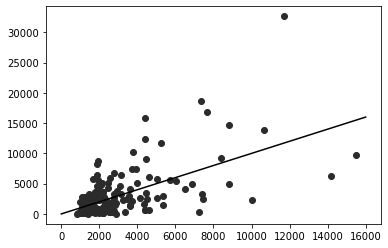

In [65]:
import matplotlib.pyplot as plt

%matplotlib inline

plt.scatter(model.predict(X_test),y_test)
plt.plot([0,16000],[0,16000],'k-')

#model is not completely accurate

In [68]:
#Use correlation to further examine the relationship between teh predicted and actual values
import numpy as np

np.corrcoef(model.predict(X_test),y_test)

#.613 is fairly strong correlation and will do a decent job in predicting

array([[1.        , 0.61257401],
       [0.61257401, 1.        ]])

In [4]:
#End 5.04